# AML Data Preprocessing

## BASICS

### --- IMPORT LIBRARIES ---

In [1]:
import torch
import time
import random
import datetime
import numpy as np
import pandas as pd
import networkx as nx
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from pandas import Timestamp
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from torch_geometric.utils import negative_sampling, train_test_split_edges


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# importing functions from functions.py
from functions import *

### --- LOAD DATASET ---

In [3]:
filename = "/Users/owhy/Documents/Datasets/HI-Small_Trans_balanced.csv"
data = pd.read_csv(filename)
print(f"Shape of DataFrame - {data.shape}")
data.head()

Shape of DataFrame - (10000, 11)


,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:12,47640,811D69990,47640,811D69990,12.57,US Dollar,12.57,US Dollar,Reinvestment,0
1,2022/09/14 12:37,19329,808B1C350,1412,809F49D20,19551.02,US Dollar,19551.02,US Dollar,ACH,1
2,2022/09/03 11:29,17769,8128ED040,223240,8128E8980,1423.23,Euro,1423.23,Euro,ACH,0
3,2022/09/09 18:44,11899,80532AFB0,29620,80AE51B90,1942.55,Australian Dollar,1942.55,Australian Dollar,Credit Card,0
4,2022/09/04 04:40,27444,80B3BFFD0,11405,80B3D2700,671.25,US Dollar,671.25,US Dollar,ACH,0


In [4]:
print("---- info ----")
data.info()

---- info ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Timestamp           10000 non-null  object 
 1   From Bank           10000 non-null  int64  
 2   Account             10000 non-null  object 
 3   To Bank             10000 non-null  int64  
 4   Account.1           10000 non-null  object 
 5   Amount Received     10000 non-null  float64
 6   Receiving Currency  10000 non-null  object 
 7   Amount Paid         10000 non-null  float64
 8   Payment Currency    10000 non-null  object 
 9   Payment Format      10000 non-null  object 
 10  Is Laundering       10000 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 859.5+ KB


In [5]:
print("---- basic calculations ----")
data.describe()

---- basic calculations ----


,From Bank,To Bank,Amount Received,Amount Paid,Is Laundering
count,10000.000000,10000.000000,1.000000e+04,1.000000e+04,10000.00000
mean,45216.034000,62562.778900,1.175696e+07,1.170495e+07,0.30000
std,78623.707753,83018.261584,8.544369e+08,8.544337e+08,0.45828
min,1.000000,1.000000,1.700000e-05,1.700000e-05,0.00000
25%,119.000000,2952.000000,3.741900e+02,3.757875e+02,0.00000
50%,11056.000000,19542.000000,2.962215e+03,2.964105e+03,0.00000
75%,29003.000000,117504.750000,1.637903e+04,1.634599e+04,1.00000
max,355908.000000,355908.000000,8.485314e+10,8.485314e+10,1.00000


#### Null elements?

In [6]:
print(data.isnull().sum())

Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64


#### Fraudulent or Not? - Y labels

In [7]:
print(f"Number of fraudulent transactions - {len(data[data["Is Laundering"]==1])}")
print(f"Number of non-fraudulent transactions - {len(data[data["Is Laundering"]==0])}")
data[data["Is Laundering"]==1]

Number of fraudulent transactions - 3000
Number of non-fraudulent transactions - 7000


,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
1,2022/09/14 12:37,19329,808B1C350,1412,809F49D20,19551.02,US Dollar,19551.02,US Dollar,ACH,1
6,2022/09/09 12:30,70,1004286A8,5365,80BA66B60,1802.50,Euro,1802.50,Euro,Credit Card,1
7,2022/09/03 07:04,2843,800A4B110,12,80026C1D0,1675.54,Euro,1675.54,Euro,ACH,1
11,2022/09/08 02:56,11852,801FDBE70,24144,801FDBEC0,4079.01,Euro,4079.01,Euro,ACH,1
13,2022/09/09 15:32,115700,806FDA270,115359,806FDB960,2394.79,US Dollar,2394.79,US Dollar,ACH,1
...,...,...,...,...,...,...,...,...,...,...,...
9991,2022/09/02 08:44,240229,80F025640,217,80FD27570,26443.70,Shekel,26443.70,Shekel,ACH,1
9993,2022/09/06 13:00,113523,8054100E0,12,80C9A5530,255663.67,Mexican Peso,255663.67,Mexican Peso,ACH,1
9994,2022/09/10 01:12,70,1004286A8,23554,80B518560,47.84,Euro,47.84,Euro,Credit Card,1
9995,2022/09/08 09:49,31149,80EB13650,15447,80E0555C0,15471.36,US Dollar,15471.36,US Dollar,ACH,1


In [8]:
laundering_accounts = list(data[data["Is Laundering"]==1]["Account"])
print(laundering_accounts)
print(f"Laundering Accounts - {laundering_accounts}")
data[data["Account"]==laundering_accounts[0]]

['808B1C350', '1004286A8', '800A4B110', '801FDBE70', '806FDA270', '80AEA5480', '80E7A2B80', '812A70ED0', '80794B6F0', '811B0AE50', '803C83D60', '100428660', '100428738', '811C599A0', '811AF52C0', '813C3BDC0', '8079ED520', '808338D40', '800278B80', '80F801A80', '1004286A8', '80050C9D0', '80FF6CD50', '80DE274E0', '80A752E60', '808338D40', '100428780', '8073E7BB0', '1004286A8', '801018DA0', '80265EBC0', '809DDA830', '8065992B0', '1004286A8', '8010D4440', '80C136480', '100428660', '8051B3BF0', '80CC04930', '80EF0F190', '8096C6720', '80CD397E0', '8000E1590', '8031FC940', '8088E7D60', '80EFADF00', '8026A1970', '812D127D0', '801783860', '8016C37F0', '1004286F0', '80027A2B0', '8045F4500', '804282480', '8001BB380', '804070990', '80126B2F0', '100428660', '807EF78D0', '802873390', '800E44770', '80416BDE0', '100428660', '811C597B0', '812DCF890', '80557A9D0', '80260FD30', '1004286A8', '80878BA20', '80BC61040', '805544690', '8021C45F0', '81255CE20', '80266F880', '8108DC0F0', '8051E3B20', '812A70ED0'

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
1,2022/09/14 12:37,19329,808B1C350,1412,809F49D20,19551.02,US Dollar,19551.02,US Dollar,ACH,1
1880,2022/09/12 18:13,19329,808B1C350,13037,8032CED30,15696.55,US Dollar,15696.55,US Dollar,ACH,1
6270,2022/09/14 09:29,19329,808B1C350,21550,80429A1C0,14189.54,US Dollar,14189.54,US Dollar,ACH,1
8925,2022/09/14 17:40,19329,808B1C350,12719,801085420,17801.52,US Dollar,17801.52,US Dollar,ACH,1


In [9]:
labels = data["Is Laundering"].to_numpy()
labels

array([0, 1, 0, ..., 0, 1, 0])

#### Checking similarities between columns

In [10]:
print("Are Amount Paid entirely equal to Amount Received?\n - " + str(data["Amount Paid"].equals(data["Amount Received"])))
print("Are Currency Received entirely equal to Currency Paid?\n - " + str(data["Payment Currency"].equals(data["Receiving Currency"])))

Are Amount Paid entirely equal to Amount Received?
 - False
Are Currency Received entirely equal to Currency Paid?
 - False


#### Checking amount of unique categories for Payments

In [11]:
print(sorted(data["Receiving Currency"].unique()))
print(sorted(data["Payment Currency"].unique()))
print(sorted(data["Payment Format"].unique()))
merged_unique_accounts = pd.concat([data["Account"], data["Account.1"]]).unique()
print(len(merged_unique_accounts))

['Australian Dollar', 'Bitcoin', 'Brazil Real', 'Canadian Dollar', 'Euro', 'Mexican Peso', 'Ruble', 'Rupee', 'Saudi Riyal', 'Shekel', 'Swiss Franc', 'UK Pound', 'US Dollar', 'Yen', 'Yuan']
['Australian Dollar', 'Bitcoin', 'Brazil Real', 'Canadian Dollar', 'Euro', 'Mexican Peso', 'Ruble', 'Rupee', 'Saudi Riyal', 'Shekel', 'Swiss Franc', 'UK Pound', 'US Dollar', 'Yen', 'Yuan']
['ACH', 'Bitcoin', 'Cash', 'Cheque', 'Credit Card', 'Reinvestment', 'Wire']
15899


## NODE MATRIX

In [12]:
unique_accounts = get_nodes(data)
unique_accounts

,Accounts,Bank,Currency
0,811D69990,47640,US Dollar
1,808B1C350,19329,US Dollar
2,8128ED040,17769,Euro
3,80532AFB0,11899,Australian Dollar
4,80B3BFFD0,27444,US Dollar
...,...,...,...
15894,80C9A5530,12,Mexican Peso
15895,80B518560,23554,Euro
15896,8003F4070,1467,US Dollar
15897,80224DF50,23885,US Dollar


#### --- One-hot encoding: currency ---

In [13]:
node_features = one_hot_encoding(unique_accounts, column="Currency")
node_features

,Accounts,Bank,Australian Dollar,Bitcoin,Brazil Real,Canadian Dollar,Euro,Mexican Peso,Ruble,Rupee,Saudi Riyal,Shekel,Swiss Franc,UK Pound,US Dollar,Yen,Yuan
0,811D69990,47640,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,808B1C350,19329,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,8128ED040,17769,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,80532AFB0,11899,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,80B3BFFD0,27444,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15894,80C9A5530,12,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
15895,80B518560,23554,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
15896,8003F4070,1467,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
15897,80224DF50,23885,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


#### --- Normalization and Vectorization ---

In [14]:
# bank and accounts as independent dataframes for vectorizaiton and normalization purposes
from_bank_col = node_features.pop('Bank')
account_col = node_features.pop('Accounts')

node_labels = pd.DataFrame(account_col)

In [15]:
# DONE add vectors as individual columns in new dataframe
df = pd.DataFrame(account_col, columns=['Accounts'])
df.reset_index(drop=True, inplace=True) # Ensure the DataFrame has the same number of rows as the original series
vectors = hashing_vectorization(df['Accounts'], vector_size=9)

# Convert vectors into DataFrame
vectors_df = pd.DataFrame(vectors, columns=[f'col_{i}' for i in range(len(vectors[0]))])
result_df = pd.concat([df, vectors_df], axis=1)
accounts_df = result_df.drop(columns=["Accounts"])

In [16]:
from_bank_binary = [bin(x).split("b")[1] for x in from_bank_col]
binary_lists = [[int(bit) for bit in binary] for binary in from_bank_binary]

In [17]:
longest_str, len_longest_str = get_longest_string_in_list(from_bank_binary)
binary_lists = make_binary_fixed_length(binary_lists, longest_str)
bin_vectors_df = pd.DataFrame(binary_lists, columns=[f'bin_{i}' for i in range(len(binary_lists[0]))])
# bin_vectors_df

Longest String is  - 1001110001110010100 w/ length - 19


In [18]:
# DONE normalize vector values to avoid big numbers
from_bank_df = pd.DataFrame(from_bank_col)
accounts_df = pd.DataFrame(accounts_df)

# DONE do not normalize at this point --> create BINARY representation
accounts_df_norm = normalize(accounts_df,0,1)
# accounts_df_norm

#### --- Final Node Features ---

In [19]:
node_features.reset_index(drop=True, inplace=True) # Ensure the DataFrame has the same number of rows as the original series
accounts_df_norm.reset_index(drop=True, inplace=True) # Ensure the DataFrame has the same number of rows as the original series

node_features = pd.concat([node_features, accounts_df_norm], axis=1)
node_features = pd.concat([node_features, bin_vectors_df], axis=1)
node_features

,Australian Dollar,Bitcoin,Brazil Real,Canadian Dollar,Euro,Mexican Peso,Ruble,Rupee,Saudi Riyal,Shekel,...,bin_9,bin_10,bin_11,bin_12,bin_13,bin_14,bin_15,bin_16,bin_17,bin_18
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,1
2,0,0,0,0,1,0,0,0,0,0,...,0,1,0,1,1,0,1,0,0,1
3,1,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,1,1,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15894,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
15895,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
15896,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,0,1,1
15897,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,0,1


#### --- Account: Unique Identifier ---

In [20]:
# DONE add unique random identified
unique_ids_set = set()
while len(unique_ids_set) < len(node_features): # uniqueness kept
    unique_ids_set.add(random.random())
unique_ids = list(unique_ids_set)
node_features.insert(0, "Unique ID", unique_ids)
node_features

,Unique ID,Australian Dollar,Bitcoin,Brazil Real,Canadian Dollar,Euro,Mexican Peso,Ruble,Rupee,Saudi Riyal,...,bin_9,bin_10,bin_11,bin_12,bin_13,bin_14,bin_15,bin_16,bin_17,bin_18
0,0.536669,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,0,0
1,0.198887,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,1
2,0.819323,0,0,0,0,1,0,0,0,0,...,0,1,0,1,1,0,1,0,0,1
3,0.236405,1,0,0,0,0,0,0,0,0,...,1,0,0,1,1,1,1,0,1,1
4,0.609624,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15894,0.997794,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
15895,0.343206,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
15896,0.206691,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,0,1,1
15897,0.143707,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,0,1


#### --- X = Node Feature Matrix ---

In [21]:
# DONE nodes should be bank accounts and not transactions. Bank accounts have unique receiving currencies and "bank BINs"
x = node_features.to_numpy()
x.shape # [num_nodes x num_features]

(15899, 44)

## EDGE MATRIX

### --- Finding Links: Mapping ---

In [22]:
links = [{'source': source, 'destination': destination} for source, destination in zip(data['Account'], data['Account.1'])]

In [23]:
links[-1]

{'source': '800499810', 'destination': '8016625C0'}

### --- Edge Features ---

In [24]:
# DONE add edge features --> create matrix like those for nodes 
edges_df = data[["Timestamp", "Amount Paid", "Payment Currency", "Payment Format"]]
edges_df

,Timestamp,Amount Paid,Payment Currency,Payment Format
0,2022/09/01 00:12,12.57,US Dollar,Reinvestment
1,2022/09/14 12:37,19551.02,US Dollar,ACH
2,2022/09/03 11:29,1423.23,Euro,ACH
3,2022/09/09 18:44,1942.55,Australian Dollar,Credit Card
4,2022/09/04 04:40,671.25,US Dollar,ACH
...,...,...,...,...
9995,2022/09/08 09:49,15471.36,US Dollar,ACH
9996,2022/09/09 19:44,182.52,US Dollar,Credit Card
9997,2022/09/03 00:07,11.35,US Dollar,Credit Card
9998,2022/09/11 17:22,3877.62,US Dollar,ACH


#### --- Payment Encoding ---

In [25]:
edges_amount = edges_df["Amount Paid"].astype(str)
edges_amount = list(edges_amount)

In [26]:
maximum = str(max(edges_df["Amount Paid"]))
max_len = len(maximum.split(".")[0])
minimum = min(edges_df["Amount Paid"])
minimum = format(minimum, 'f')
min_len = len(str(minimum.split('.')[1]))

new_min, count = count_unused_decimals(minimum)
min_len = min_len - count

number_columns = max_len + min_len
number_columns

17

In [27]:
a = split_into_vectors(edges_amount) # INEFFICIENT !!!! # INEFFICIENT !!!!# INEFFICIENT !!!!# INEFFICIENT !!!!# INEFFICIENT !!!!

new_payment_list = encode_payment_amount(a, max_len, min_len) # INEFFICIENT !!!! # INEFFICIENT !!!!# INEFFICIENT !!!!# INEFFICIENT !!!!# INEFFICIENT !!!!
new_payment_list = nested_list_int = [[int(item) for item in sublist] for sublist in new_payment_list]

In [28]:
# Convert vectors into DataFrame
payment_vectors_df = pd.DataFrame(new_payment_list, columns=[f'payment_{i}' for i in range(len(new_payment_list[0]))])

# ...
edges_features = pd.concat([edges_df, payment_vectors_df], axis=1)
edges_features.drop("Amount Paid", axis='columns')

,Timestamp,Payment Currency,Payment Format,payment_0,payment_1,payment_2,payment_3,payment_4,payment_5,payment_6,payment_7,payment_8,payment_9,payment_10,payment_11,payment_12,payment_13,payment_14,payment_15,payment_16
0,2022/09/01 00:12,US Dollar,Reinvestment,0,0,0,0,0,0,0,0,0,1,2,5,7,0,0,0,0
1,2022/09/14 12:37,US Dollar,ACH,0,0,0,0,0,0,1,9,5,5,1,0,2,0,0,0,0
2,2022/09/03 11:29,Euro,ACH,0,0,0,0,0,0,0,1,4,2,3,2,3,0,0,0,0
3,2022/09/09 18:44,Australian Dollar,Credit Card,0,0,0,0,0,0,0,1,9,4,2,5,5,0,0,0,0
4,2022/09/04 04:40,US Dollar,ACH,0,0,0,0,0,0,0,0,6,7,1,2,5,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2022/09/08 09:49,US Dollar,ACH,0,0,0,0,0,0,1,5,4,7,1,3,6,0,0,0,0
9996,2022/09/09 19:44,US Dollar,Credit Card,0,0,0,0,0,0,0,0,1,8,2,5,2,0,0,0,0
9997,2022/09/03 00:07,US Dollar,Credit Card,0,0,0,0,0,0,0,0,0,1,1,3,5,0,0,0,0
9998,2022/09/11 17:22,US Dollar,ACH,0,0,0,0,0,0,0,3,8,7,7,6,2,0,0,0,0


#### --- One-hot encoding: currency ---

In [29]:
# DONE convert Currency into one-hot encoding
positions = edges_features["Payment Currency"].str.split(",", expand=True) # creating new columns by splitting receiving currency --> all are added
edges_features["first_position"] = positions[0] # first currency in each row is extracted --> actual currency used and that we want as TRUE
# One-hot encoding
edges_features = pd.concat([edges_features, pd.get_dummies(edges_features["first_position"],dtype='int')], axis=1, join='inner') # effectively adds actual currency to dummy variables/columns
edges_features.drop(["Amount Paid","Payment Currency", "first_position"], axis=1, inplace=True) # drop the axiliary columns
edges_features.head()

,Timestamp,Payment Format,payment_0,payment_1,payment_2,payment_3,payment_4,payment_5,payment_6,payment_7,...,Mexican Peso,Ruble,Rupee,Saudi Riyal,Shekel,Swiss Franc,UK Pound,US Dollar,Yen,Yuan
0,2022/09/01 00:12,Reinvestment,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2022/09/14 12:37,ACH,0,0,0,0,0,0,1,9,...,0,0,0,0,0,0,0,1,0,0
2,2022/09/03 11:29,ACH,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2022/09/09 18:44,Credit Card,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2022/09/04 04:40,ACH,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [30]:
# DONE convert Payment Format
positions_2 = edges_features["Payment Format"].str.split(",", expand=True)
edges_features["second_position"] = positions_2[0]
edges_features = pd.concat([edges_features, pd.get_dummies(edges_features["second_position"],dtype='int')], axis=1, join='inner') # effectively adds actual currency to dummy variables/columns
edges_features.drop(["Payment Format", "second_position"], axis=1, inplace=True) # drop the axiliary columns
edges_features.head()

,Timestamp,payment_0,payment_1,payment_2,payment_3,payment_4,payment_5,payment_6,payment_7,payment_8,...,US Dollar,Yen,Yuan,ACH,Bitcoin,Cash,Cheque,Credit Card,Reinvestment,Wire
0,2022/09/01 00:12,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,2022/09/14 12:37,0,0,0,0,0,0,1,9,5,...,1,0,0,1,0,0,0,0,0,0
2,2022/09/03 11:29,0,0,0,0,0,0,0,1,4,...,0,0,0,1,0,0,0,0,0,0
3,2022/09/09 18:44,0,0,0,0,0,0,0,1,9,...,0,0,0,0,0,0,0,1,0,0
4,2022/09/04 04:40,0,0,0,0,0,0,0,0,6,...,1,0,0,1,0,0,0,0,0,0


#### --- One-hot encoding: time ---

In [31]:
# DONE convert timestamps --> higher number --> more recent 
edges_features["Timestamp"] = ((pd.to_datetime(edges_features['Timestamp']).astype(int) // 10**9) - 1661990000) // 10 # does not interpret time well... circular definition for months --> sinus calculations
edges_features

,Timestamp,payment_0,payment_1,payment_2,payment_3,payment_4,payment_5,payment_6,payment_7,payment_8,...,US Dollar,Yen,Yuan,ACH,Bitcoin,Cash,Cheque,Credit Card,Reinvestment,Wire
0,112,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,116902,0,0,0,0,0,0,1,9,5,...,1,0,0,1,0,0,0,0,0,0
2,21454,0,0,0,0,0,0,0,1,4,...,0,0,0,1,0,0,0,0,0,0
3,75904,0,0,0,0,0,0,0,1,9,...,0,0,0,0,0,0,0,1,0,0
4,27640,0,0,0,0,0,0,0,0,6,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,64054,0,0,0,0,0,0,1,5,4,...,1,0,0,1,0,0,0,0,0,0
9996,76264,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
9997,17362,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
9998,92692,0,0,0,0,0,0,0,3,8,...,1,0,0,1,0,0,0,0,0,0


In [32]:
# split for normalization purposes: only time & payments
df_requires_normalization, second_df = split_dataframe(edges_features)
df_requires_normalization = normalize(df_requires_normalization)
edges_features = pd.concat([df_requires_normalization,second_df], axis=1)

In [33]:
edges_features

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,US Dollar,Yen,Yuan,ACH,Bitcoin,Cash,Cheque,Credit Card,Reinvestment,Wire
0,0.000477,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,1,0,0,0,0,0,0,0,1,0
1,0.774187,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,1.000000,0.555556,...,1,0,0,1,0,0,0,0,0,0
2,0.141863,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.111111,0.444444,...,0,0,0,1,0,0,0,0,0,0
3,0.502584,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.111111,1.000000,...,0,0,0,0,0,0,0,1,0,0
4,0.182844,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.666667,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.424080,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.555556,0.444444,...,1,0,0,1,0,0,0,0,0,0
9996,0.504969,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.111111,...,1,0,0,0,0,0,0,1,0,0
9997,0.114755,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,1,0,0,0,0,0,0,1,0,0
9998,0.613801,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.333333,0.888889,...,1,0,0,1,0,0,0,0,0,0


### --- Y - Edge Feature Matrix

In [34]:
y = edges_features.to_numpy()
# print(y[0:10])

# GRAPHICAL - nx

In [35]:
graph_full = create_graph(links, edges_amount)

[('811D69990', '811D69990', {'label': '12.57'}), ('808B1C350', '809F49D20', {'label': '19551.02'}), ('808B1C350', '80878BA20', {'label': '6791.69'}), ('808B1C350', '8032CED30', {'label': '15696.55'}), ('808B1C350', '80391BE70', {'label': '5462.9'}), ('808B1C350', '801253D80', {'label': '15081.26'}), ('808B1C350', '80070AA30', {'label': '18927.02'}), ('808B1C350', '80429A1C0', {'label': '14189.54'}), ('808B1C350', '801085420', {'label': '17801.52'}), ('808B1C350', '80CE8FDA0', {'label': '17904.38'}), ('8128ED040', '8128E8980', {'label': '1423.23'}), ('80532AFB0', '80AE51B90', {'label': '1942.55'}), ('80532AFB0', '8081AB1E0', {'label': '646.65'}), ('80B3BFFD0', '80B3D2700', {'label': '671.25'}), ('80B819F30', '80E54F210', {'label': '167794.19'}), ('1004286A8', '80BA66B60', {'label': '1802.5'}), ('1004286A8', '811060DC0', {'label': '2428.36'}), ('1004286A8', '811614660', {'label': '31.44'}), ('1004286A8', '801673D30', {'label': '76260.59'}), ('1004286A8', '802646860', {'label': '68695.87'

In [36]:
print(graph_full)

Graph with 15899 nodes and 9768 edges


### --- Visualization ---

In [37]:
# DONE Creating smaller graph for visualization:
limit = 150
small_graph = create_graph(links, edges_amount, limit=limit)

[('811D69990', '811D69990', {'label': '12.57'}), ('808B1C350', '809F49D20', {'label': '19551.02'}), ('8128ED040', '8128E8980', {'label': '1423.23'}), ('80532AFB0', '80AE51B90', {'label': '1942.55'}), ('80B3BFFD0', '80B3D2700', {'label': '671.25'}), ('80B819F30', '80E54F210', {'label': '167794.19'}), ('1004286A8', '80BA66B60', {'label': '1802.5'}), ('1004286A8', '811060DC0', {'label': '2428.36'}), ('1004286A8', '811614660', {'label': '31.44'}), ('1004286A8', '801673D30', {'label': '76260.59'}), ('1004286A8', '802646860', {'label': '68695.87'}), ('800A4B110', '80026C1D0', {'label': '1675.54'}), ('8012ACCD0', '8015CF360', {'label': '412.97'}), ('802A085F0', '80B2F5C60', {'label': '892.96'}), ('810B00D90', '812673520', {'label': '1008.92'}), ('801FDBE70', '801FDBEC0', {'label': '4079.01'}), ('805330470', '80B7D1580', {'label': '139969.75'}), ('806FDA270', '806FDB960', {'label': '2394.79'}), ('80A7807A0', '80A7807A0', {'label': '22.11'}), ('811E5DE80', '811FFAFF0', {'label': '14453.41'}), (

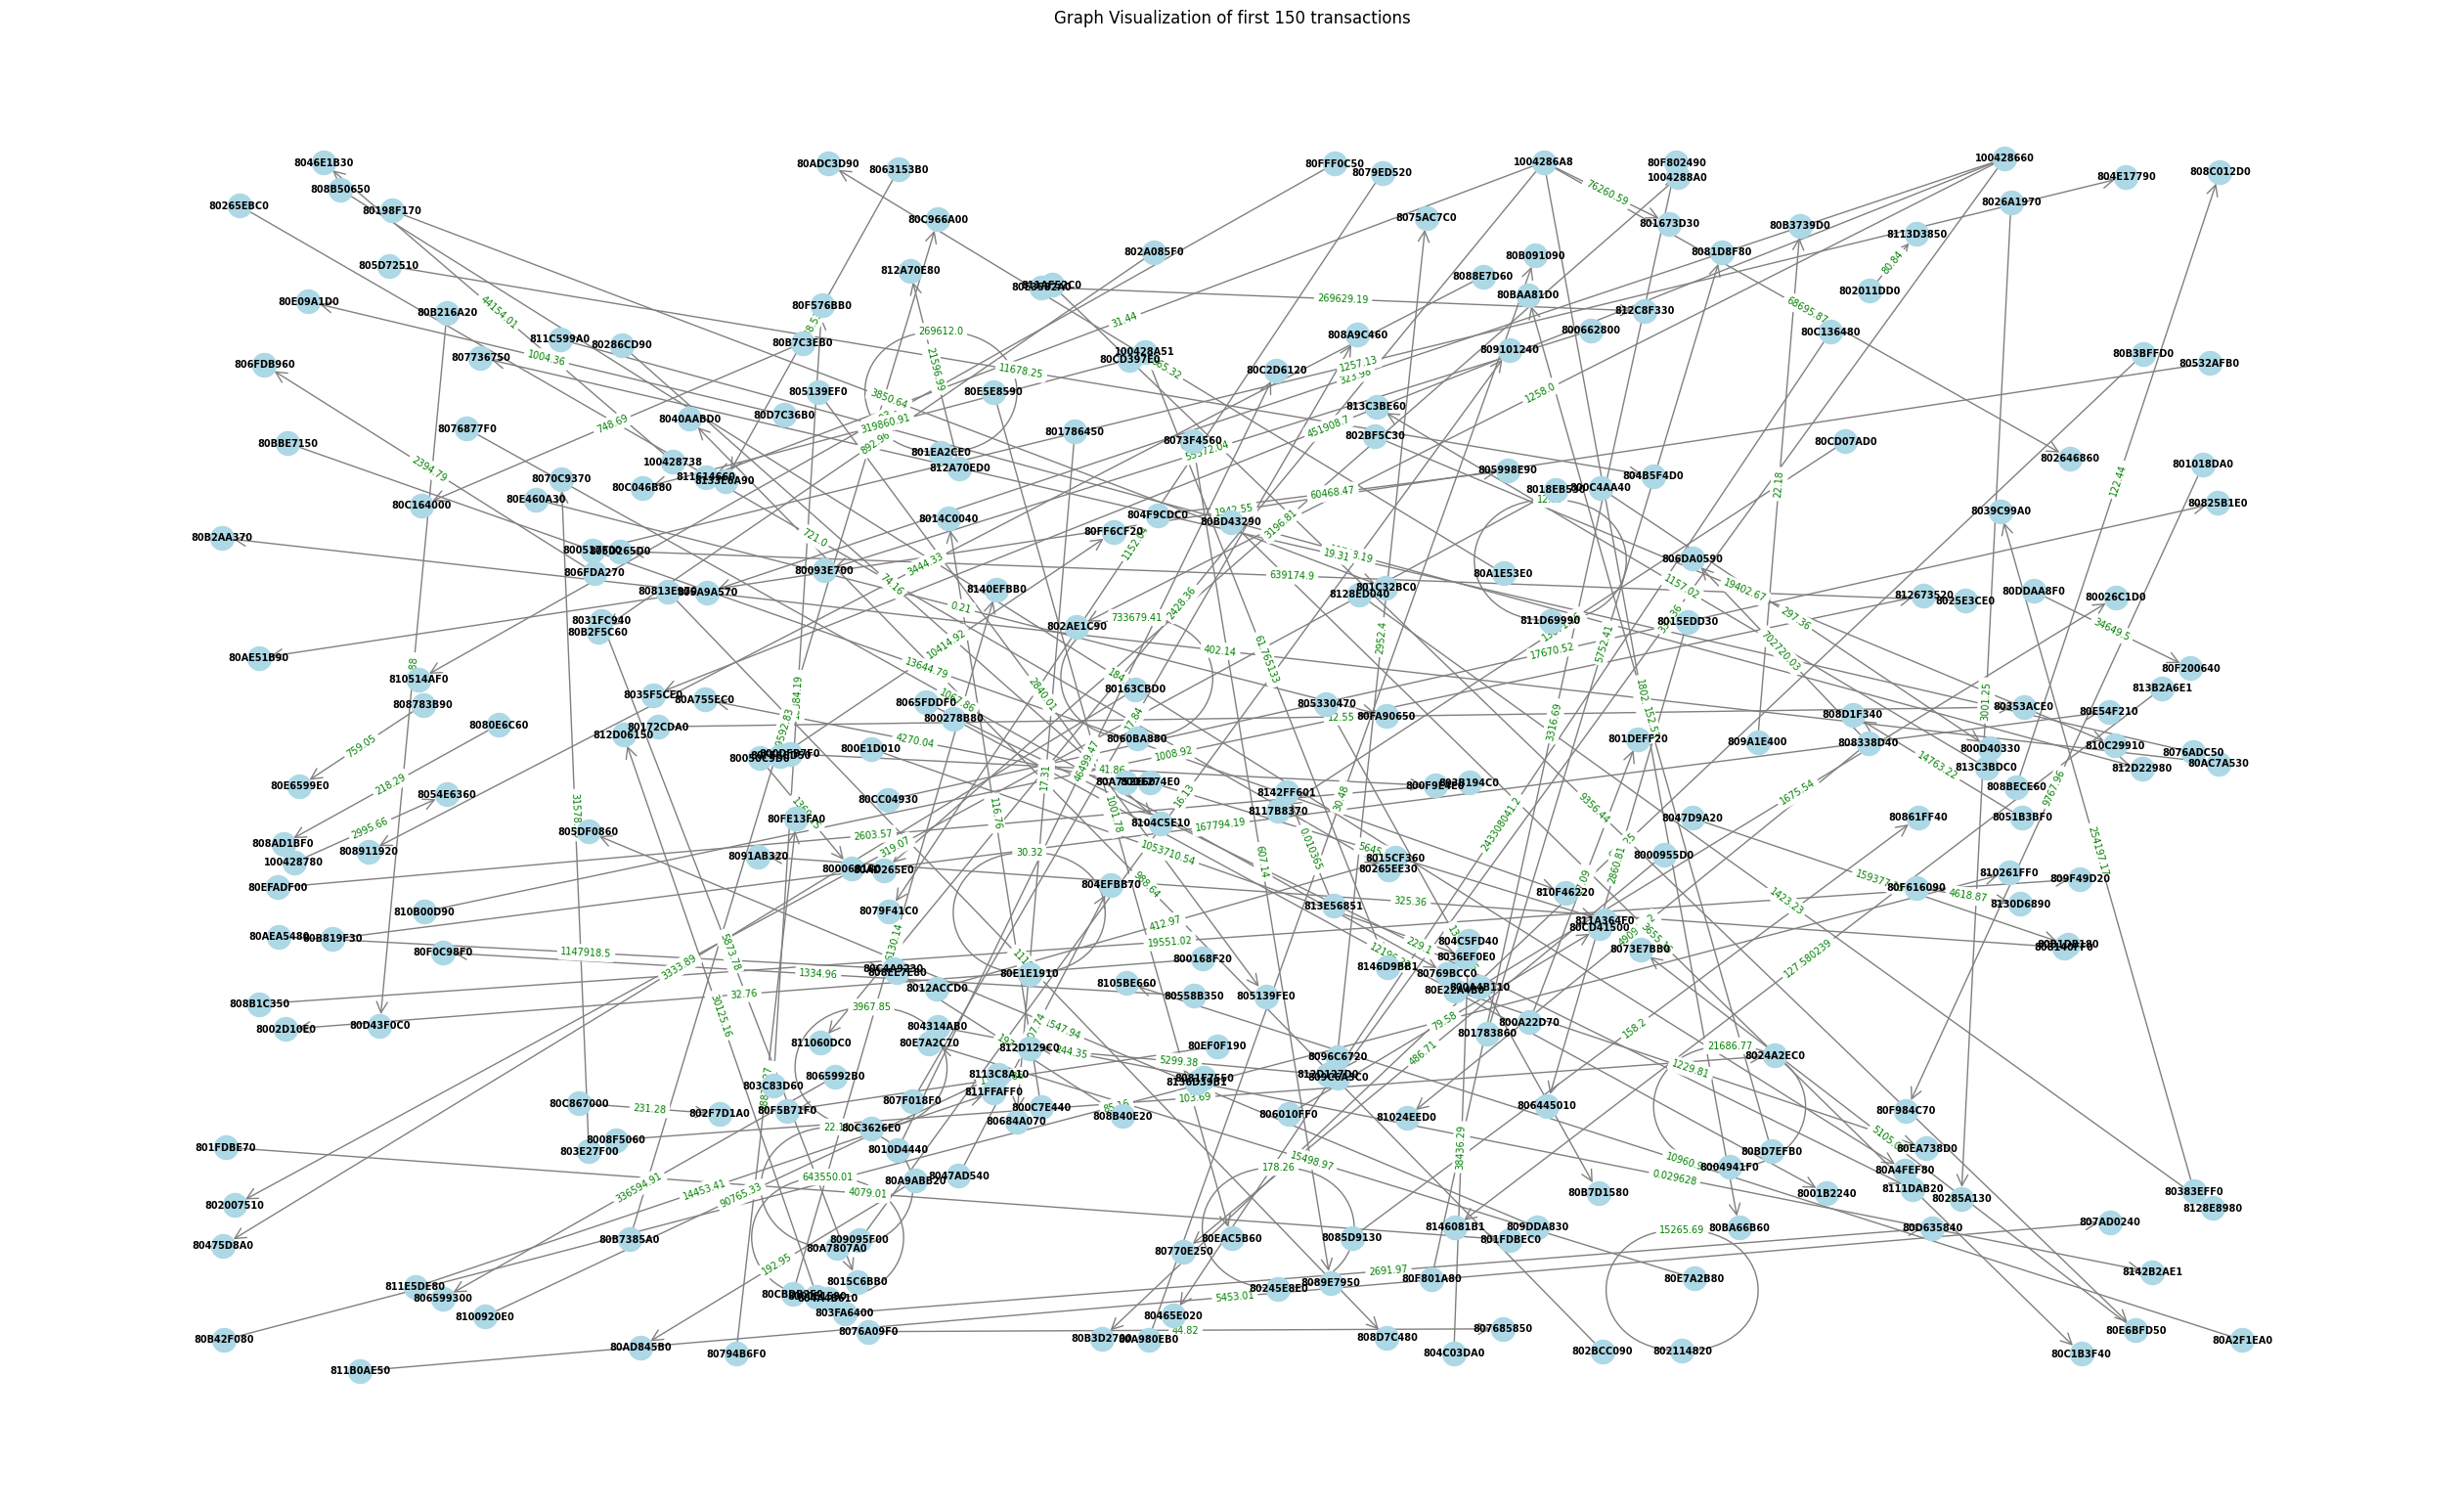

In [38]:
pos = nx.random_layout(small_graph) # shell, circular, spectral, spring, random,
plt.figure(figsize=(25, 15))  # Increase figure size

nx.draw(
    small_graph,
    pos,
    node_size=300,  # Reduce node size for better visibility
    with_labels=True,
    font_size=7,
    font_weight='bold',
    node_color='lightblue',  # Specify node color
    edge_color='gray',  # Specify edge color
    width=1,  # Adjust edge width
    arrows=True,  # Show arrows for directed edges
    arrowstyle='->',  # Specify arrow style
    arrowsize=20,  # Adjust arrow size
)

edge_labels = nx.get_edge_attributes(small_graph, 'label')
nx.draw_networkx_edge_labels(
    small_graph,
    pos,
    edge_labels=edge_labels,
    label_pos=0.5,  # Adjust label position along edges
    font_size=7,  # Adjust font size
    font_color='green',  # Specify font color
)

if 'limit' in locals():
    plt.title(f'Graph Visualization of first {limit} transactions')  # Add title to the plot
else:
    plt.title(f'Graph Visualization of all transactions')  # Add title to the plot
plt.axis('off')  # Hide axis
plt.show()

#### --- Statistical elements as additional features for nodes ---

In [39]:
# Dictionaries
degree_of_centrality = nx.degree_centrality(small_graph) # closeness_centrality, eigenvector_centrality, betweenness_centrality
betweenness_centrality = nx.betweenness_centrality(small_graph)

# TODO add statistics to a new DataFrame 

node_stat_features = pd.DataFrame()
node_stat_features['account'] = degree_of_centrality.keys()
node_stat_features['degree_of_centrality'] = degree_of_centrality.values()
node_stat_features['betweenness_centrality'] = betweenness_centrality.values()
node_stat_features

,account,degree_of_centrality,betweenness_centrality
0,811D69990,0.007143,0.0
1,808B1C350,0.003571,0.0
2,809F49D20,0.003571,0.0
3,8128ED040,0.003571,0.0
4,8128E8980,0.003571,0.0
...,...,...,...
276,8004941F0,0.007143,0.0
277,80B42F080,0.003571,0.0
278,810261FF0,0.003571,0.0
279,801783860,0.003571,0.0


# ADJACENCY MATRIX - nx

### --- Loading full graph ---

In [40]:
print(len(edges_features))
print(len(links)) # number of transactions

10000
10000


In [41]:
print(len(unique_accounts))
print(graph_full.__len__()) # number of nodes in the graph

15899
15899


In [42]:
adjacency_matrix = nx.adjacency_matrix(graph_full)
adjacency_matrix

<15899x15899 sparse array of type '<class 'numpy.int64'>'
	with 18699 stored elements in Compressed Sparse Row format>

In [43]:
print("Number of nodes:", graph_full.number_of_nodes())
print("Shape of adjacency matrix:", adjacency_matrix.shape)

Number of nodes: 15899
Shape of adjacency matrix: (15899, 15899)


#### number in adjacency matrix does not match edges --> creating alternative matching

In [44]:
accounts = unique_accounts.reset_index(drop=True)
accounts['ID'] = accounts.index
mapping_dict = dict(zip(accounts['Accounts'], accounts['ID']))
data['From'] = data['Account'].map(mapping_dict)
data['To'] = data['Account.1'].map(mapping_dict)
data = data.drop(['Account', 'Account.1', 'From Bank', 'To Bank'], axis=1)
data


,Timestamp,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,From,To
0,2022/09/01 00:12,12.57,US Dollar,12.57,US Dollar,Reinvestment,0,0,0
1,2022/09/14 12:37,19551.02,US Dollar,19551.02,US Dollar,ACH,1,1,8136
2,2022/09/03 11:29,1423.23,Euro,1423.23,Euro,ACH,0,2,8137
3,2022/09/09 18:44,1942.55,Australian Dollar,1942.55,Australian Dollar,Credit Card,0,3,8138
4,2022/09/04 04:40,671.25,US Dollar,671.25,US Dollar,ACH,0,4,8139
...,...,...,...,...,...,...,...,...,...
9995,2022/09/08 09:49,15471.36,US Dollar,15471.36,US Dollar,ACH,1,8132,5569
9996,2022/09/09 19:44,182.52,US Dollar,182.52,US Dollar,Credit Card,0,3390,15896
9997,2022/09/03 00:07,11.35,US Dollar,11.35,US Dollar,Credit Card,0,8133,15897
9998,2022/09/11 17:22,3877.62,US Dollar,3877.62,US Dollar,ACH,1,8134,1125


In [45]:
edge_index = torch.stack([torch.from_numpy(data['From'].values), torch.from_numpy(data['To'].values)], dim=0)
print(edge_index)
print(edge_index.size())

tensor([[    0,     1,     2,  ...,  8133,  8134,  8135],
        [    0,  8136,  8137,  ..., 15897,  1125, 15898]])
torch.Size([2, 10000])


In [46]:
adjacency_matrix = adjacency_matrix.todense()
adjacency_matrix

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]])

In [47]:
print(adjacency_matrix) # index of nodes
print(len(adjacency_matrix))

[[1 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]]
15899


In [48]:
print(type(adjacency_matrix))

<class 'numpy.ndarray'>


In [49]:
adjacency_matrix = torch.from_numpy(adjacency_matrix).to(torch.float)
print(adjacency_matrix.size())

torch.Size([15899, 15899])


In [50]:
num_ones = (adjacency_matrix == 1).sum().item()
print("Number of ones:", num_ones)

Number of ones: 18699


In [51]:
# edge_index = torch.tensor(np.array(adjacency_matrix.nonzero()), dtype=torch.long)
# edge_index
# print(edge_index.size())

In [52]:
node_features = node_features.to_numpy()
edges_features = edges_features.to_numpy()

In [53]:
print(node_features)
print(edges_features)

[[0.53666889 0.         0.         ... 0.         0.         0.        ]
 [0.19888694 0.         0.         ... 0.         0.         1.        ]
 [0.81932346 0.         0.         ... 0.         0.         1.        ]
 ...
 [0.20669086 0.         0.         ... 0.         1.         1.        ]
 [0.14370721 0.         0.         ... 1.         0.         1.        ]
 [0.56333078 0.         0.         ... 0.         1.         1.        ]]
[[4.76985452e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [7.74187137e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.41863423e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.14754750e-01 0.00000000e+00 0.00000000e+00 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.13800779e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.50616106e-01 0.00000000e+00 0.00000000e+00 ... 0.000

In [54]:
node_features = torch.from_numpy(node_features).to(torch.float)
edges_features = torch.from_numpy(edges_features).to(torch.float)
labels = torch.from_numpy(labels).to(torch.float)

In [55]:
print(node_features.size())
print(edges_features.size())
print(edge_index.size())
print(labels.size())

torch.Size([15899, 44])
torch.Size([10000, 40])
torch.Size([2, 10000])
torch.Size([10000])


In [56]:
input_data = Data(
    x=node_features,
    edge_index=edge_index,
    edge_attr=edges_features,
    y=labels
)

print(input_data)
print(input_data.y.size())

Data(x=[15899, 44], edge_index=[2, 10000], edge_attr=[10000, 40], y=[10000])
torch.Size([10000])


In [57]:
print(input_data)

Data(x=[15899, 44], edge_index=[2, 10000], edge_attr=[10000, 40], y=[10000])


In [58]:
import pickle

with open("Saved-Data/graph.pickle", "wb") as f:
    pickle.dump({
        'edges_features': edges_features,
        'links': links,
        'unique_accounts': unique_accounts,
        'graph_full': graph_full,
        'adjacency_matrix': adjacency_matrix,
        'node_features': node_features,
        'edge_index': edge_index,
        'labels': labels,
        'input_data': input_data
    }, f)

# -------- !!! TODO !!! ----------

In [59]:
# PLAN MONDAY 
# FIX Model input Data 
# TODO Create equivalent variables but flip nodes with edges 

# DONE Understand architecture 
# DONE Understand model input data 
# DONE There are missing connections in the adjacency matrix # IDEA scrap adjacency matrix entirely if necessary? 
# DONE Create model without NeighborSampler 
# DONE Clean code 
# DONE Make model work ... 

# PLAN TUESDAY 
# TODO CODE - Make model more extensive 
# TODO CODE - Visualize prediction patterns and learning curve for existing model 
# TODO CODE - Create testing stage and evaluation 
# TODO ADMIN - Send email with Update (ask about servers?
# TODO THEORY - Watch GNN Theory 
# TODO THEORY - Write up Introduction 

# PLAN WEDNESDAY 
# TODO THEORY - Understand Math Theory 
# TODO THEORY - Write up methodology theory 
# TODO THEORY - Write up Literature Review 

# PLAN THURSDAY 
# TODO CODE - add statistics to a new DataFrame 
# TODO CODE - add average of transactions for accounts 